## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'india_air_quality'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['AP001_AT (degree C)',
 'AP001_BP (mmHg)',
 'AP001_Benzene (ug/m3)',
 'AP001_CO (mg/m3)',
 'AP001_NH3 (ug/m3)',
 'AP001_NO (ug/m3)',
 'AP001_NO2 (ug/m3)',
 'AP001_NOx (ppb)',
 'AP001_Ozone (ug/m3)',
 'AP001_PM10 (ug/m3)',
 'AP001_PM2.5 (ug/m3)',
 'AP001_RF (mm)',
 'AP001_RH (%)',
 'AP001_SO2 (ug/m3)',
 'AP001_SR (W/mt2)',
 'AP001_Temp (degree C)',
 'AP001_Toluene (ug/m3)',
 'AP001_VWS (m/s)',
 'AP001_WD (deg)',
 'AP001_WS (m/s)',
 'AP001_Xylene (ug/m3)',
 'AP002_AT (degree C)',
 'AP002_BP (mmHg)',
 'AP002_Benzene (ug/m3)',
 'AP002_CO (mg/m3)',
 'AP002_Eth-Benzene (ug/m3)',
 'AP002_MP-Xylene (ug/m3)',
 'AP002_NH3 (ug/m3)',
 'AP002_NO (ug/m3)',
 'AP002_NO2 (ug/m3)',
 'AP002_NOx (ppb)',
 'AP002_O Xylene (ug/m3)',
 'AP002_Ozone (ug/m3)',
 'AP002_PM10 (ug/m3)',
 'AP002_PM2.5 (ug/m3)',
 'AP002_RF (mm)',
 'AP002_RH (%)',
 'AP002_SO2 (ug/m3)',
 'AP002_SR (W/mt2)',
 'AP002_Toluene (ug/m3)',
 'AP002_VWS (degree)',
 'AP002_WD (deg)',
 'AP002_WS (m/s)',
 'AP003_AT (degree C)',
 'AP003_BP (mmHg)',

## Converting TAG Name Format
* After checking all the Tag Names from the India Air Quality dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names AP001.

In [5]:
# Set the desired tag names
tags = name[:21]

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'AP001_AT (degree C)','AP001_BP (mmHg)','AP001_Benzene (ug/m3)','AP001_CO (mg/m3)','AP001_NH3 (ug/m3)','AP001_NO (ug/m3)','AP001_NO2 (ug/m3)','AP001_NOx (ppb)','AP001_Ozone (ug/m3)','AP001_PM10 (ug/m3)','AP001_PM2.5 (ug/m3)','AP001_RF (mm)','AP001_RH (%)','AP001_SO2 (ug/m3)','AP001_SR (W/mt2)','AP001_Temp (degree C)','AP001_Toluene (ug/m3)','AP001_VWS (m/s)','AP001_WD (deg)','AP001_WS (m/s)','AP001_Xylene (ug/m3)'


## Load India Air Quality Dataset
* Load the data using tag names

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'india_air_quality'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time = quote('2016-07-01 10:00:00')
# Set the data end time
end_time = quote('2023-03-31 23:00:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Move 'value' column to the end
    df['AP001_NO2 (ug/m3)'] = df.pop('AP001_NO2 (ug/m3)')
        
    return df

In [8]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

NAME,AP001_AT (degree C),AP001_BP (mmHg),AP001_Benzene (ug/m3),AP001_CO (mg/m3),AP001_NH3 (ug/m3),AP001_NO (ug/m3),AP001_NOx (ppb),AP001_Ozone (ug/m3),AP001_PM10 (ug/m3),AP001_PM2.5 (ug/m3),...,AP001_RH (%),AP001_SO2 (ug/m3),AP001_SR (W/mt2),AP001_Temp (degree C),AP001_Toluene (ug/m3),AP001_VWS (m/s),AP001_WD (deg),AP001_WS (m/s),AP001_Xylene (ug/m3),AP001_NO2 (ug/m3)
TIME,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,23.05,925.25,1.000000,0.480000,7.07,17.67,32.330000,14.50,39.000000,10.670000,...,71.670000,6.600,123.670000,33.430000,4.63,-0.10,226.33,2.300000,0.10,39.200000
2016-07-01 11:00:00,23.56,925.25,0.700000,0.490000,7.40,20.50,35.800000,15.00,39.000000,2.000000,...,70.000000,6.545,186.000000,33.700000,4.50,-0.10,223.00,2.500000,0.10,41.900000
2016-07-01 12:00:00,24.07,925.25,0.666667,0.483333,7.05,18.80,34.793333,13.50,42.666667,8.166667,...,67.833333,6.490,204.166667,33.656667,4.50,-0.10,223.00,2.293333,0.10,42.466667
2016-07-01 13:00:00,24.58,925.25,0.633333,0.476667,6.70,17.10,33.786667,12.00,46.333333,14.333333,...,65.666667,6.435,222.333333,33.613333,4.50,-0.10,223.00,2.086667,0.10,43.033333
2016-07-01 14:00:00,25.09,925.25,0.600000,0.470000,6.35,15.40,32.780000,10.50,50.000000,20.500000,...,63.500000,6.380,240.500000,33.570000,4.50,-0.10,223.00,1.880000,0.10,43.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,25.23,749.00,1.550000,1.160000,8.30,11.03,41.520000,12.30,70.250000,53.000000,...,72.750000,3.680,10.750000,30.570000,5.15,-0.20,310.00,0.450000,0.85,61.150000
2023-03-31 20:00:00,24.62,749.00,2.350000,1.070000,7.45,9.22,35.270000,11.17,88.500000,58.500000,...,78.500000,3.020,11.000000,30.650000,5.28,-0.20,173.50,0.350000,1.05,52.230000
2023-03-31 21:00:00,24.23,749.00,1.720000,0.850000,7.25,3.40,21.350000,10.60,80.500000,44.250000,...,82.500000,1.620,11.000000,30.680000,4.12,-0.20,37.00,0.350000,0.73,34.950000


In [9]:
# Train data: from 2016 to 2022.12.31
# Test data: 2023

train = df[df.index < '2023-01-01']
test = df[(df.index.year == 2023)]

## Data Preprocessing
* 1 Min-Max Scaling

### 1. Applying Min-Max Scaling
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

In [10]:
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply scalers
train_ = scaler_data.fit_transform(train.iloc[:, :-1].values)
train_t = scaler_target.fit_transform(train.iloc[:, -1:].values)

test_ = scaler_data.transform(test.iloc[:, :-1].values)
test_t = scaler_target.transform(test.iloc[:, -1:].values)

# Set each DataFrames
train_scaled = pd.DataFrame(train_)  
train_scaled['NO2'] = train_t

test_scaled = pd.DataFrame(test_)
test_scaled['NO2'] = test_t

## Dataset & Loader Setup

In [11]:
class Air_Dataset(Dataset):
    def __init__(self, data, target_column, seq_length=10):
        self.data = data
        self.target_column = target_column
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Input data: Values of multiple variables over seq_length - 1
        x = self.data[idx:idx + self.seq_length - 1].drop(columns=[self.target_column]).values.reshape(-1, self.seq_length-1)  # Excluding target column
        # Target data: Target variable value on the seq_length 
        y = self.data[self.target_column].iloc[idx + self.seq_length - 1]
        return x, y

In [12]:
# Set up datasets  
train_ = Air_Dataset(train_scaled, target_column='NO2', seq_length=2)
test_ = Air_Dataset(test_scaled, target_column='NO2', seq_length=2)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=64, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([64, 20, 1])


## Model Configuration
* Using Temporal Convolutional Network(TCN) model.

In [14]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation  # Set padding based on kernel size and dilation
        # First 1D convolution layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        # Second 1D convolution layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Construct the sequence of layers
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        
        # Downsample for residual connection if needed
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        # Trim the output to match the input size (fixing size mismatch due to padding)
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, 
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)  # Output layer for regression tasks

    def forward(self, x):
        x = self.network(x)
        x = x[:, :, -1]  # Use the output from the last time step
        return self.linear(x)

In [15]:
# Model configuration parameters
input_channels = 20
hidden_channels = [25, 50, 75, 100] 
kernel_size = 3
dropout = 0.2

# Learning rate
learning_rate = 0.001

# Initialize the model, loss, and optimizer
model = TCN(num_inputs=input_channels, num_channels=hidden_channels, kernel_size=kernel_size, dropout=dropout).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(20, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(20, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(20, 25, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(25, 50, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(4,),

## Model Training

* Save the model with the Best Loss.

In [16]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
    
        # Calculate loss
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')  

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Air_Quality_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



train loss: 0.004167357712111901
Model saved

train loss: 0.004062100977364033
Model saved

train loss: 0.0039060621852661584
Model saved

train loss: 0.0035781261981184804
Model saved

train loss: 0.0033321022362978723
Model saved

train loss: 0.003155101261729321
Model saved

train loss: 0.0030128025385550198
Model saved

train loss: 0.0028891162651376113
Model saved

train loss: 0.0027901083804738945
Model saved

train loss: 0.0027025631624762693
Model saved

train loss: 0.002624268408212317
Model saved

train loss: 0.0025512497537792432
Model saved

train loss: 0.00248068092128629
Model saved

train loss: 0.0024191319441723073
Model saved

train loss: 0.0023602438892237885
Model saved

train loss: 0.0023048782616735233
Model saved

train loss: 0.0022519740989590154
Model saved

train loss: 0.0022061994405397824
Model saved

train loss: 0.0021569486773941556
Model saved

train loss: 0.002109668532843953
Model saved

train loss: 0.002064329540204296
Model saved

train loss: 0.002019

## Model Testing

In [21]:
# Load the best model
model_ = torch.load(f'./result/Air_Quality_General.pt')

In [22]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[: -1].cpu()
last_values_pred = combined_tensor_pred[: -1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [23]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 46.61501
R² Score: 0.8604429382551197


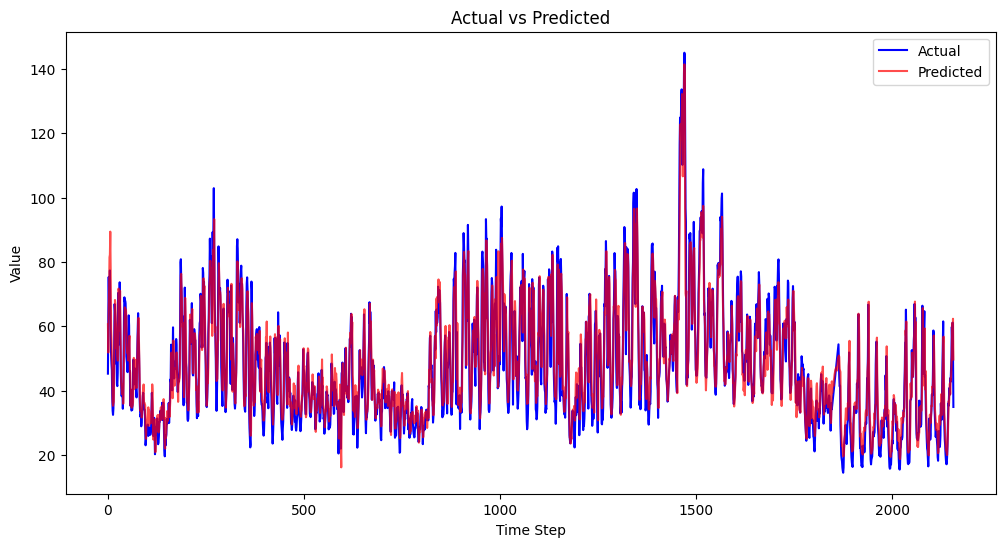

In [24]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()